**6/1/20**

I'm going to use this notebook to answer some basic quesitons about the results of the various database searches to compare against other proteomic publications. These questions include: How many human and bacterial proteins did my search identify? Is the distribution of spectral hits for peptides normal, or do I need to run them through a log transformation before performing statistical tests? Does the search identify about the same number of PSMs in each sample, or does it vary? What percent of the PSMs in BV+ samples are human vs. BV-?

In [1]:
from elliot_utils import *

In [2]:
results = getOrderedFiles(TAILORED_RESULTS, '.tsv')
comResults = getOrderedFiles(COMMUNITY_RESULTS, '.tsv')
combResults = getOrderedFiles(POOLED_RESULTS, '.tsv')
indResults = getOrderedFiles(SINGLE_RESULTS, '.tsv')
hybResults = getOrderedFiles(HYBRID_RESULTS, '.tsv')
analysisPath = Path.cwd().joinpath('analysis_files/basic_search_results/')
figPath = Path.cwd().joinpath('figures/basic_search_results/')

Determine the number of unique human and bacterial proteins identified by my searches

In [3]:
# Prints the number of unique human and bacterial proteins identified in the set of results.
# Requires a set of human filtered peptides and bacterial filtered peptides.
def reportUniqueProteins(humanPeps, bacteriaPeps, results):
    peptidePool = set()
    peptidePool.update(humanPeps)
    peptidePool.update(bacteriaPeps)
    protsIDd = {} # key=protein ID, value=set of peptides that match this protein
    pep2Prots = {} # key=peptide sequence, value=set of proteins that match this peptide
    pepCounts = {} # key=peptide sequence, value=number of times identified across all samples
    pepProbabilities = {} # key=peptide sequence, value=lowest spectral probability
    for pep in peptidePool:
        pep2Prots[pep] = set()
        pepCounts[pep] = 0
        pepProbabilities[pep] = 1000000000
    for res in results:
        with res.open(mode='r') as infile:
            reader = csv.reader(infile, delimiter='\t')
            for row in reader:
                protType = determineIDType(row)
                if protType == 'first':
                    continue
                if not isSignificant(row):
                    break
                if (protType == 'human' and row[PEPTIDE] in humanPeps) or (protType == 'bacteria' and row[PEPTIDE] in bacteriaPeps):
                    pepCounts[row[PEPTIDE]] += 1
                    if pepProbabilities[row[PEPTIDE]] > float(row[SPEC_PROBABILITY]):
                        pepProbabilities[row[PEPTIDE]] = float(row[SPEC_PROBABILITY])
                    hits = getProteinHitList(row, protType)
                    pep2Prots[row[PEPTIDE]].update(set(hits))
                    for hit in hits:
                        if not hit in protsIDd.keys():
                            protsIDd[hit] = set()
                        protsIDd[hit].add(row[PEPTIDE])

    humanRealProts = set()
    bacteriaRealProts = set()
    peptidesCopy = peptidePool.copy()
    for prot, pepSet in protsIDd.items():
        validPeps = set()
        for pep in pepSet:
            if pep in peptidesCopy:
                validPeps.add(pep)
        if len(validPeps) > 1:
            if prot.find('HUMAN') != -1:
                humanRealProts.add(prot)
            else:
                bacteriaRealProts.add(prot)
            for p in validPeps:
                peptidesCopy.remove(p)
    for pep, count in pepCounts.items():
        if pep in peptidesCopy and count > 1:
            realProt = pep2Prots[pep].pop()
            if realProt.find('HUMAN') != -1:
                humanRealProts.add(realProt)
            else:
                bacteriaRealProts.add(realProt)
            peptidesCopy.remove(pep)
    for pep, probability in pepProbabilities.items():
        if pep in peptidesCopy and probability < 1e-15:
            peptidesCopy.remove(pep)
            realProt = pep2Prots[pep].pop()
            if realProt.find('HUMAN') != -1:
                humanRealProts.add(realProt)
            else:
                bacteriaRealProts.add(realProt)
    print(f'Unique Human Proteins: {len(humanRealProts)}')
    print(f'Unique Bacterial Proteins {len(bacteriaRealProts)}')

In [4]:
humanPeps = getFilteredPeptides(results, 'human')
bacteriaPeps = getFilteredPeptides(results, 'bacteria')

In [6]:
# Determine how many human and bacterial proteins have 2 unique peptides identified, one peptide identified twice, or one peptide with spec < 1e-15
print('16S_Sample-Matched')
reportUniqueProteins(humanPeps, bacteriaPeps, results)

16S_Sample-Matched
Unique Human Proteins: 1074
Unique Bacterial Proteins 1257


In [7]:
# Unique proteins for 16S_Pooled
comHumanPeps = getFilteredPeptides(comResults, 'human')
comBacteriaPeps = getFilteredPeptides(comResults, 'bacteria')

In [8]:
print('16S_Pooled')
reportUniqueProteins(comHumanPeps, comBacteriaPeps, comResults)

16S_Pooled
Unique Human Proteins: 798
Unique Bacterial Proteins 1022


In [9]:
# Unique proteins for Shotgun_Pooled
combHumanPeps = getFilteredPeptides(combResults, 'human')
combBacteriaPeps = getFilteredPeptides(combResults, 'bacteria')

In [10]:
print('Shotgun_Pooled')
reportUniqueProteins(combHumanPeps, combBacteriaPeps, combResults)

Shotgun_Pooled
Unique Human Proteins: 820
Unique Bacterial Proteins 1037


In [11]:
# Unique proteins for Shotgun_Sample-Matched
indHumanPeps = getFilteredPeptides(indResults, 'human')
indBacteriaPeps = getFilteredPeptides(indResults, 'bacteria')

In [12]:
print('Shotgun_Sample-Matched')
reportUniqueProteins(indHumanPeps, indBacteriaPeps, indResults)

Shotgun_Sample-Matched
Unique Human Proteins: 1182
Unique Bacterial Proteins 942


In [9]:
# Unique proteins for Hybrid_Sample-Matched
hybHumanPeps = getFilteredPeptides(hybResults, 'human')
hybBacteriaPeps = getFilteredPeptides(hybResults, 'bacteria')

In [15]:
print('Hybrid_Sample-Matched')
reportUniqueProteins(hybHumanPeps, hybBacteriaPeps, hybResults)

Hybrid_Sample-Matched
Unique Human Proteins: 1068
Unique Bacterial Proteins 1418


Of the samples with species between 1% and 0.1% abundance, determine the number of significant PSMs that match exclusively and non-exclusively to them, and what percent of the total PSMs for those samples those PSMs represent.

In [5]:
abundanceDataFile = Path.cwd().joinpath('analysis_files/hybrid_vs_tailored/taxa_abundance.csv')
abundanceData = pd.read_csv(abundanceDataFile)

In [6]:
# Get samples that have species with 1% > abundance > 0.1%, and what those species are
lowAbundRef = {} # key=sample name, value=[low_abundance_taxa_1, low_abundance_taxa_2...]
for i in abundanceData.index:
    if not abundanceData['sample'][i] in lowAbundRef.keys():
        lowAbundRef[str(abundanceData['sample'][i])] = []
    if abundanceData['abundance'][i] < 1 and abundanceData['abundance'][i] > 0.1:
        lowAbundRef[str(abundanceData['sample'][i])].append(abundanceData['taxa'][i])

In [7]:
hybProtRefs = []
for db in getOrderedFiles(HYBRID_DB, '.fasta'):
    hybProtRefs.append(ProtRef(db))

In [10]:
# Get the number of significant PSMs from hybrid results that only match bacteria with 1% > abundance > 0.1% in each sample.
totalPSMs = {} # key=sample name, value=total bacterial PSMs
exclusiveLowPSMs = {} # key=sample name, value=bacterial PSMs exclusively matching low-abundance taxa
promiscuousLowPSMs = {} # key=sample name, value=bacterial PSMs that match a low-abundance taxa
for i in range(len(hybResults)):
    sampleName = hybResults[i].name[0:4]
    if len(lowAbundRef[sampleName]) == 0:
        continue
    totalPSMs[sampleName] = 0
    exclusiveLowPSMs[sampleName] = 0
    promiscuousLowPSMs[sampleName] = 0
    with hybResults[i].open(mode='r') as infile:
        reader = csv.reader(infile, delimiter='\t')
        for row in reader:
            protType = determineIDType(row)
            if protType == 'first':
                continue
            if not isSignificant(row):
                break
            if protType == 'bacteria' and row[PEPTIDE] in hybBacteriaPeps:
                totalPSMs[sampleName] += 1
                hitProteins = getProteinHitList(row, 'bacteria')
                hitTaxa = set()
                for hit in hitProteins:
                    for t in hybProtRefs[i].getProt(hit).taxa:
                        hitTaxa.add(t)
                lowAbundanceTaxa = set()
                highAbundanceTaxa = set()
                for taxa in hitTaxa:
                    if taxa in lowAbundRef[sampleName]:
                        lowAbundanceTaxa.add(taxa)
                    else:
                        highAbundanceTaxa.add(taxa)
                if len(lowAbundanceTaxa) > 0:
                    promiscuousLowPSMs[sampleName] += 1
                    if len(highAbundanceTaxa) == 0:
                        exclusiveLowPSMs[sampleName] += 1

In [11]:
# Calculate percent of bacterial PSMs in each sample that match low abundance taxa, and present average:
percentsPromiscuous = []
for key in totalPSMs.keys():
    percentsPromiscuous.append((promiscuousLowPSMs[key] / totalPSMs[key]) * 100)
print(f'Average percent promiscuous matches to low abundance taxa: {sum(percentsPromiscuous) / len(percentsPromiscuous)}%')
percentsExclusive = []
for key in totalPSMs.keys():
    percentsExclusive.append((exclusiveLowPSMs[key] / totalPSMs[key]) * 100)
print(f'Average percent exclusive matches to low abundance taxa: {sum(percentsExclusive) / len(percentsExclusive)}%')

Average percent promiscuous matches to low abundance taxa: 2.743222269425245%
Average percent exclusive matches to low abundance taxa: 0.6818667099308564%


In [12]:
# Show list of percents promiscuous and percents exclusive
print('Promiscuous:')
print(percentsPromiscuous)
print('Exclusive:')
print(percentsExclusive)

Promiscuous:
[27.77777777777778, 3.007518796992481, 11.538461538461538, 0.42662116040955633, 0.0, 0.16498247061249743, 0.37344398340248963, 0.0, 0.15552099533437014, 0.8361204013377926, 0.4357298474945534, 0.546448087431694, 2.4922118380062304, 0.46666666666666673, 1.5384615384615385, 0.0, 0.5893909626719057, 0.5070993914807302, 2.2346368715083798, 0.29455081001472755, 1.0752688172043012, 0.0, 18.095238095238095, 0.20060180541624875, 0.0, 1.0135135135135136, 0.2967359050445104]
Exclusive:
[15.079365079365079, 0.0, 0.9615384615384616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14727540500736377, 0.0, 0.0, 2.2222222222222223, 0.0, 0.0, 0.0, 0.0]


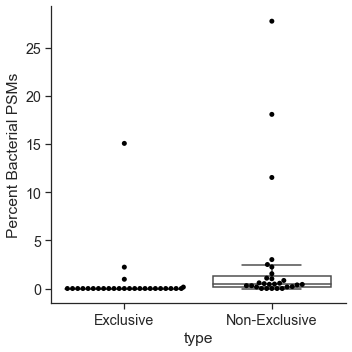

In [47]:
# Graph the percent of bacterial PSMs in each sample that match low abundance taxa, and present average:
percents = []
dataType = []
for i in range(len(percentsExclusive)):
    percents.append(percentsExclusive[i])
    dataType.append('Exclusive')
    percents.append(percentsPromiscuous[i])
    dataType.append('Non-Exclusive')
lowTaxaDF = pd.DataFrame({'Percent Bacterial PSMs':percents, 'type':dataType})
plot = sns.catplot(x='type', y='Percent Bacterial PSMs', data=lowTaxaDF, kind='swarm', color='black')
ax = plot.axes[0]
sns.boxplot(x='type', y='Percent Bacterial PSMs', data=lowTaxaDF, boxprops={'facecolor':'None'}, showfliers=False, ax=ax[0])